# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('dark_background')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [54]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import itertools

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [127]:
%load_ext autoreload
%autoreload 2
from src.utils import fetch_eng_data, load_train_data, load_test_data, window_avg_sd, normalize_data, add_labels
from src.utils import gen_sequence, gen_labels

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preparation

## Loading Data

In [64]:
fetch_eng_data()

All files in place


In [125]:
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

Load data using function `load_data` imported from module `utils`:

In [117]:
df1 = load_train_data(1)
df_test = load_test_data(1)

df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,20
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,20
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,20
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,20


In [118]:
df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,20
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,20
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,20
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,20


In [91]:
df1 = normalize_data(df1)
df_test = normalize_data(df_test)

In [120]:
df1 = add_labels(df1)

In [122]:
df_test = add_labels(df_test)

In [123]:
df_test

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,f30,f10
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,30,1,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,29,1,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,28,1,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,27,1,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,26,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8.4715,0.03,394,2388,100.0,38.65,23.1974,4,2,1
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8.4512,0.03,395,2388,100.0,38.57,23.2771,3,2,1
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8.4569,0.03,395,2388,100.0,38.62,23.2051,2,2,1
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8.4711,0.03,395,2388,100.0,38.66,23.2699,1,2,1


## Label training data
Calculate end of life (EOL) and remainining useful life (RUL)

In [8]:
df1.id.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [9]:
train1_fail = df1.groupby('id').cycle.max()
train1_fail

id
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64

<AxesSubplot:>

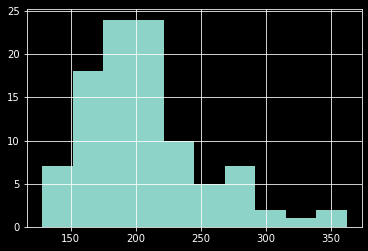

In [10]:
train1_fail.hist()

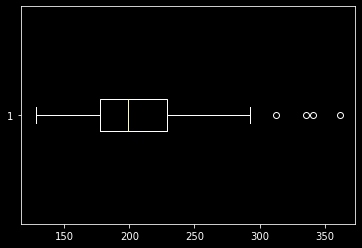

In [11]:
plt.boxplot(train1_fail, vert=False);

In [12]:
df1['eol'] = df1['id'].apply(lambda x: train1_fail[x])
df1.eol.unique()

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 202, 168, 147, 230, 199, 156,
       165, 194, 191, 200, 181, 128, 216, 196, 256, 214, 231, 215, 198,
       213, 257, 193, 275, 137, 172, 185, 174, 283, 153, 313, 362, 208,
       166, 229, 210, 154, 293, 267, 278, 178, 217, 135, 341, 155, 258,
       336])

In [13]:
df1['RUL'] = df1['eol'] - df1['cycle']
df1['f30'] = df1['RUL'].apply(lambda x: 2 if x <= 10 else 1 if x <=30 else 0)
df1['f10'] = df1['RUL'].apply(lambda x: 1 if x <= 10 else 0)
df1[['RUL','f30','f10']]

,RUL,f30,f10
0,191,0,0
1,190,0,0
2,189,0,0
3,188,0,0
4,187,0,0
...,...,...,...
20626,4,2,1
20627,3,2,1
20628,2,2,1
20629,1,2,1


## Window for rolling average and sd


In [14]:
win = 5
sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(1,22) }

Add rolling averages and standard deviations to dataframe using function `window_avg_sd` from module `utils`
```python
for s, agg in sensor.items():
    for id in train1_fail.index:
        avg = df1[s].groupby(df1['id']).rolling(window=win, min_periods=4).mean()
        sd = df1[s].groupby(df1['id']).rolling(window=win, min_periods=4).std()
            
    df1.insert(len(df1.columns)-4, f'{agg[0]}', avg.values)
    df1.insert(len(df1.columns)-4, f'{agg[1]}', sd.values)
```            

In [15]:
window_avg_sd(df1)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,a19,sd19,a20,sd20,a21,sd21,eol,RUL,f30,f10
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,192,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,192,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,192,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,100.0,0.0,38.9725,0.076322,23.390175,0.037977,192,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,100.0,0.0,38.9580,0.073621,23.393020,0.033498,192,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,100.0,0.0,38.4080,0.163003,23.079640,0.086540,200,4,2,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,100.0,0.0,38.3560,0.142583,23.096120,0.093479,200,3,2,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,100.0,0.0,38.3500,0.137113,23.078180,0.116735,200,2,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,100.0,0.0,38.3320,0.138094,23.064500,0.112731,200,1,2,1


In [16]:
df1.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,a19,sd19,a20,sd20,a21,sd21,eol,RUL,f30,f10
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20331.0,20331.0,20331.000000,20331.000000,20331.000000,20331.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,100.0,0.0,38.819460,0.095229,23.291584,0.056795,216.615724,107.807862,0.203577,0.053318
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.0,0.0,0.152363,0.034040,0.091568,0.020140,50.028600,68.880990,0.518442,0.224672
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,100.0,0.0,38.326000,0.008367,23.011400,0.005331,128.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,100.0,0.0,38.728000,0.070711,23.237530,0.042205,185.000000,51.000000,0.000000,0.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,100.0,0.0,38.836000,0.093005,23.300660,0.055736,207.000000,103.000000,0.000000,0.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,100.0,0.0,38.932000,0.117175,23.359670,0.069893,240.000000,155.000000,0.000000,0.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,100.0,0.0,39.186000,0.237634,23.507160,0.166190,362.000000,361.000000,2.000000,1.000000


In [17]:
df1[["s1","s2","s3","s4","s5","s6","s7"]].describe()

,s1,s2,s3,s4,s5,s6,s7
count,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000
mean,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711
std,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092
min,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000
25%,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000
50%,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000
75%,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000
max,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000


In [18]:
df1[["s8","s9","s10","s11","s12","s13","s14"]].describe()

,s8,s9,s10,s11,s12,s13,s14
count,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000
mean,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722
std,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176
min,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000
25%,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000
50%,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000
75%,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000
max,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000


In [19]:
df1[["s15","s16","s17","s18","s19","s20","s21"]].describe()

,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## Visualizing

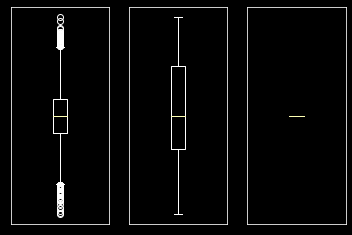

In [20]:
fig, axs = plt.subplots(1,3)
for i in range(3):
    axs[i].boxplot(df1.iloc[:,i+2])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

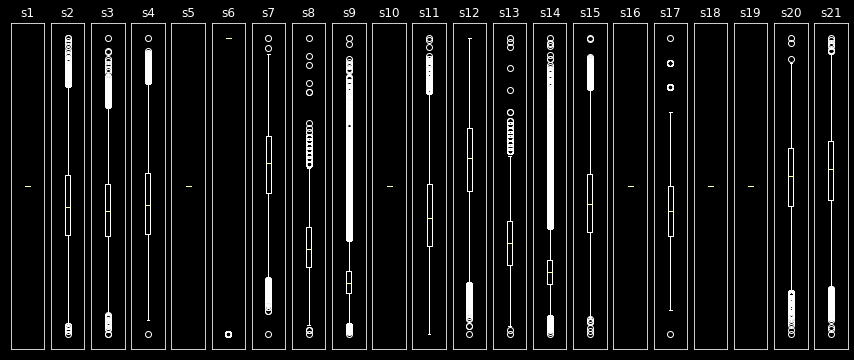

In [21]:
fig, axs = plt.subplots(1,21, figsize=(15,6))
for i in range(21):
    axs[i].boxplot(df1.iloc[:,i+5])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'{df1.columns[i+5]}')

/home/arcweld/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:89: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/home/arcweld/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:90: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/home/arcweld/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


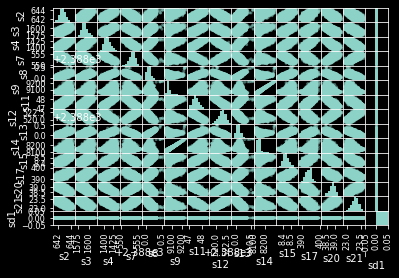

In [22]:
scatter_matrix(df1.iloc[:,np.r_[6,7,8,11,12,13,15,16,17,18,19,21,24,25,27]]);

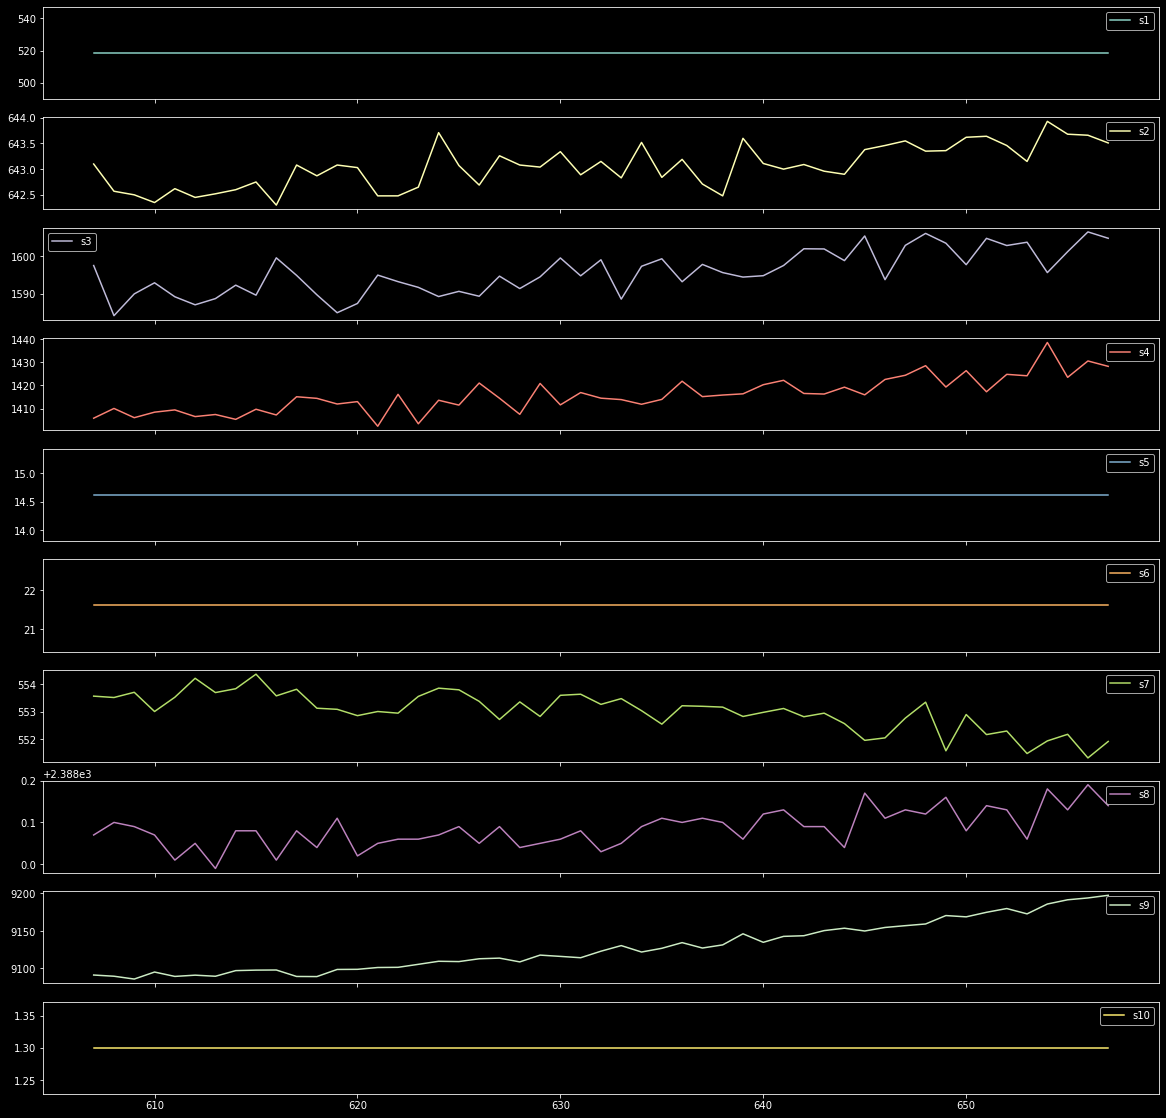

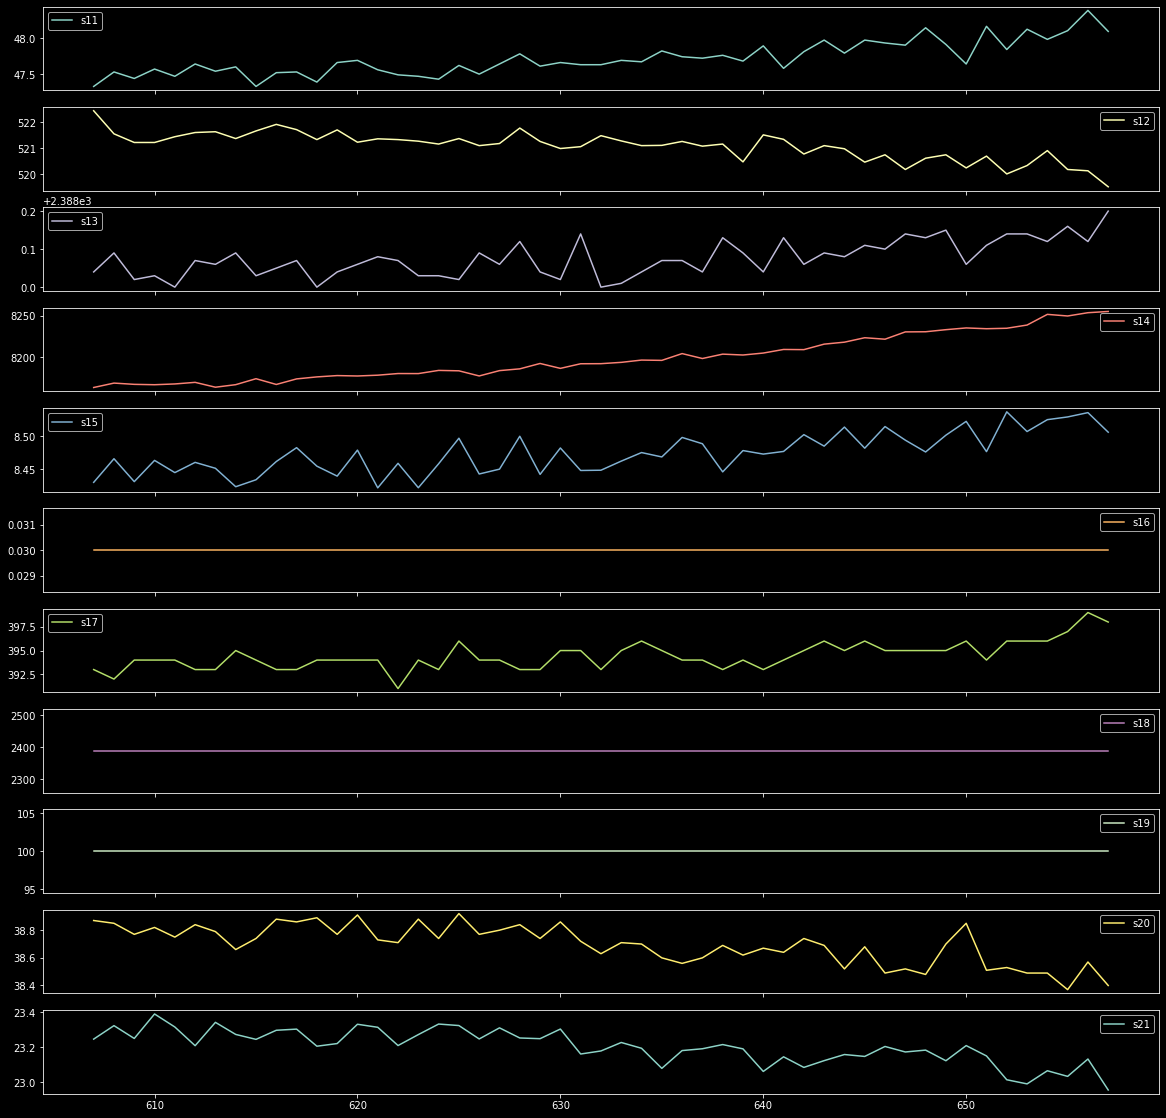

In [56]:
engine_id3 = df1[df1['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 . For now Databricks did not support pandas.plot()
engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 11-21 
engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20));

## Pipelining

In [23]:
df2 = load_data(2)
df3 = load_data(3)
df4 = load_data(4)

In [24]:
window_avg_sd(df2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,a19,sd19,a20,sd20,a21,sd21,eol,RUL,f30,f10
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,NaN,NaN,NaN,NaN,NaN,NaN,149,148,0,0
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,NaN,NaN,NaN,NaN,NaN,NaN,149,147,0,0
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,NaN,NaN,NaN,NaN,NaN,NaN,149,146,0,0
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,96.2325,7.535000,12.4525,2.271305,7.55400,1.372753,149,145,0,0
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,93.9720,8.254179,12.7880,2.105213,7.74892,1.266217,149,144,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,96.9860,6.739509,23.2100,11.173818,13.88144,6.733590,316,4,2,1
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,100.0000,0.000000,25.9740,10.067094,15.57158,6.071510,316,3,2,1
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,96.9860,6.739509,26.6940,8.731963,16.01682,5.249863,316,2,2,1
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,93.9720,8.254179,23.8320,10.260710,14.30254,6.187078,316,1,2,1


In [25]:
window_avg_sd(df3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,a19,sd19,a20,sd20,a21,sd21,eol,RUL,f30,f10
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,259,258,0,0
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,259,257,0,0
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,NaN,NaN,NaN,NaN,NaN,NaN,259,256,0,0
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,100.0,0.0,38.9775,0.106888,23.36620,0.063467,259,255,0,0
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,100.0,0.0,39.0100,0.117686,23.38462,0.068685,259,254,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,518.67,643.78,1596.01,1424.11,14.62,...,100.0,0.0,38.4480,0.083785,23.09312,0.086981,152,4,2,1
24716,100,149,0.0034,-0.0003,100.0,518.67,643.29,1596.38,1429.14,14.62,...,100.0,0.0,38.4620,0.085849,23.06022,0.095895,152,3,2,1
24717,100,150,-0.0016,0.0004,100.0,518.67,643.84,1604.53,1431.41,14.62,...,100.0,0.0,38.4660,0.080808,23.03666,0.067549,152,2,2,1
24718,100,151,-0.0023,0.0004,100.0,518.67,643.94,1597.56,1426.57,14.62,...,100.0,0.0,38.4460,0.106442,23.02680,0.053677,152,1,2,1


In [26]:
df1.columns, df3.columns

(Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21', 'a1', 'sd1', 'a2',
        'sd2', 'a3', 'sd3', 'a4', 'sd4', 'a5', 'sd5', 'a6', 'sd6', 'a7', 'sd7',
        'a8', 'sd8', 'a9', 'sd9', 'a10', 'sd10', 'a11', 'sd11', 'a12', 'sd12',
        'a13', 'sd13', 'a14', 'sd14', 'a15', 'sd15', 'a16', 'sd16', 'a17',
        'sd17', 'a18', 'sd18', 'a19', 'sd19', 'a20', 'sd20', 'a21', 'sd21',
        'eol', 'RUL', 'f30', 'f10'],
       dtype='object'),
 Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21', 'a1', 'sd1', 'a2',
        'sd2', 'a3', 'sd3', 'a4', 'sd4', 'a5', 'sd5', 'a6', 'sd6', 'a7', 'sd7',
        'a8', 'sd8', 'a9', 'sd9', 'a10', 'sd10', 'a11', 'sd11', 'a12', 'sd12',
      

In [27]:
df1.dropna(inplace=True)
X1 = df1[['cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21', 'a1', 'sd1', 'a2',
        'sd2', 'a3', 'sd3', 'a4', 'sd4', 'a5', 'sd5', 'a6', 'sd6', 'a7', 'sd7',
        'a8', 'sd8', 'a9', 'sd9', 'a10', 'sd10', 'a11', 'sd11', 'a12', 'sd12',
        'a13', 'sd13', 'a14', 'sd14', 'a15', 'sd15', 'a16', 'sd16', 'a17',
        'sd17', 'a18', 'sd18', 'a19', 'sd19', 'a20', 'sd20', 'a21', 'sd21']]
y1 = df1[['RUL','f10','f30']]
y1_reg = df1[['RUL']]
y1_cl = df1[['f10','f30']]

In [28]:
X1.info(), y1_reg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20331 entries, 3 to 20630
Data columns (total 67 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cycle     20331 non-null  int64  
 1   setting1  20331 non-null  float64
 2   setting2  20331 non-null  float64
 3   setting3  20331 non-null  float64
 4   s1        20331 non-null  float64
 5   s2        20331 non-null  float64
 6   s3        20331 non-null  float64
 7   s4        20331 non-null  float64
 8   s5        20331 non-null  float64
 9   s6        20331 non-null  float64
 10  s7        20331 non-null  float64
 11  s8        20331 non-null  float64
 12  s9        20331 non-null  float64
 13  s10       20331 non-null  float64
 14  s11       20331 non-null  float64
 15  s12       20331 non-null  float64
 16  s13       20331 non-null  float64
 17  s14       20331 non-null  float64
 18  s15       20331 non-null  float64
 19  s16       20331 non-null  float64
 20  s17       20331 non-null  in

(None, None)

In [29]:
X2 = df2[['cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']]
y2 = df2[['RUL','f10','f30']]

In [30]:
df3.dropna(inplace=True)
X3 = df3[['cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
        's15', 's16', 's17', 's18', 's19', 's20', 's21', 'a1', 'sd1', 'a2',
        'sd2', 'a3', 'sd3', 'a4', 'sd4', 'a5', 'sd5', 'a6', 'sd6', 'a7', 'sd7',
        'a8', 'sd8', 'a9', 'sd9', 'a10', 'sd10', 'a11', 'sd11', 'a12', 'sd12',
        'a13', 'sd13', 'a14', 'sd14', 'a15', 'sd15', 'a16', 'sd16', 'a17',
        'sd17', 'a18', 'sd18', 'a19', 'sd19', 'a20', 'sd20', 'a21', 'sd21']]
y3 = df3[['RUL','f10','f30']]
y3_reg = df3[['RUL']]
y3_cl = df3[['f10','f30']]

In [31]:
X4 = df4[['cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21']]
y4 = df4[['RUL','f10','f30']]

In [32]:
X1.describe()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21
count,20331.000000,20331.000000,20331.000000,20331.0,2.033100e+04,20331.000000,20331.000000,20331.000000,2.033100e+04,20331.000000,...,20331.000000,20331.000000,20331.0,20331.0,20331.0,20331.0,20331.000000,20331.000000,20331.000000,20331.000000
mean,110.383897,-0.000008,0.000003,100.0,5.186700e+02,642.685296,1590.575620,1409.028818,1.462000e+01,21.609810,...,393.184794,0.890348,2388.0,0.0,100.0,0.0,38.819460,0.095229,23.291584,0.056795
std,68.145208,0.002189,0.000293,0.0,6.525785e-11,0.500442,6.137026,9.001927,3.376937e-12,0.001367,...,1.260928,0.333876,0.0,0.0,0.0,0.0,0.152363,0.034040,0.091568,0.020140
min,4.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,...,390.000000,0.000000,2388.0,0.0,100.0,0.0,38.326000,0.008367,23.011400,0.005331
25%,54.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.330000,1586.320000,1402.450000,1.462000e+01,21.610000,...,392.200000,0.707107,2388.0,0.0,100.0,0.0,38.728000,0.070711,23.237530,0.042205
50%,105.000000,0.000000,0.000000,100.0,5.186700e+02,642.650000,1590.170000,1408.130000,1.462000e+01,21.610000,...,393.000000,0.836660,2388.0,0.0,100.0,0.0,38.836000,0.093005,23.300660,0.055736
75%,157.000000,0.001500,0.000300,100.0,5.186700e+02,643.010000,1594.450000,1414.675000,1.462000e+01,21.610000,...,394.000000,1.140175,2388.0,0.0,100.0,0.0,38.932000,0.117175,23.359670,0.069893
max,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,...,397.600000,2.489980,2388.0,0.0,100.0,0.0,39.186000,0.237634,23.507160,0.166190


In [33]:
X2.describe()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,...,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000,53759.000000
mean,109.154746,23.998407,0.572056,94.046020,472.910207,579.672399,1419.971013,1205.442024,8.031986,11.600746,...,266.069034,2334.557253,8066.597682,9.329654,0.023326,348.309511,2228.806358,97.756838,20.789296,12.473423
std,69.180569,14.747376,0.310016,14.237735,26.389707,37.289399,105.946341,119.123428,3.613839,5.431802,...,137.659507,128.068271,84.837950,0.749335,0.004711,27.754515,145.327980,5.364067,9.869331,5.921615
min,1.000000,0.000000,0.000000,60.000000,445.000000,535.530000,1243.730000,1023.770000,3.910000,5.710000,...,129.120000,2027.610000,7848.360000,8.335700,0.020000,303.000000,1915.000000,84.930000,10.180000,6.010500
25%,52.000000,10.004600,0.250700,100.000000,445.000000,549.570000,1352.760000,1123.655000,3.910000,5.720000,...,131.520000,2387.900000,8062.140000,8.677800,0.020000,331.000000,2212.000000,100.000000,10.910000,6.546300
50%,104.000000,25.001300,0.700000,100.000000,462.540000,555.980000,1369.180000,1138.890000,7.050000,9.030000,...,183.200000,2388.080000,8082.540000,9.310900,0.020000,335.000000,2223.000000,100.000000,14.880000,8.929200
75%,157.000000,41.998000,0.840000,100.000000,491.190000,607.340000,1499.370000,1306.850000,10.520000,15.490000,...,371.260000,2388.170000,8127.195000,9.386900,0.030000,369.000000,2324.000000,100.000000,28.470000,17.083200
max,378.000000,42.008000,0.842000,100.000000,518.670000,644.520000,1612.880000,1439.230000,14.620000,21.610000,...,523.370000,2390.480000,8268.500000,11.066900,0.030000,399.000000,2388.000000,100.000000,39.340000,23.590100


In [34]:
X3.describe()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,a17,sd17,a18,sd18,a19,sd19,a20,sd20,a21,sd21
count,24420.000000,24420.000000,24420.000000,24420.0,2.442000e+04,24420.000000,24420.000000,24420.000000,2.442000e+04,24420.000000,...,24420.000000,24420.000000,24420.0,24420.0,24420.0,24420.0,24420.000000,24420.000000,24420.000000,24420.000000
mean,140.761057,-0.000024,0.000005,100.0,5.186700e+02,642.460845,1588.123693,1404.541215,1.462000e+01,21.595786,...,392.538665,0.887813,2388.0,0.0,100.0,0.0,38.989027,0.096262,23.393166,0.057067
std,98.270099,0.002195,0.000294,0.0,6.673554e-11,0.523719,6.816595,9.785704,3.590091e-12,0.018160,...,1.512685,0.326392,0.0,0.0,0.0,0.0,0.226435,0.035012,0.136238,0.020806
min,4.000000,-0.008600,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,21.450000,...,389.000000,0.000000,2388.0,0.0,100.0,0.0,38.298000,0.005477,23.004040,0.002068
25%,65.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.080000,1583.330000,1397.240000,1.462000e+01,21.580000,...,391.400000,0.547723,2388.0,0.0,100.0,0.0,38.842000,0.070852,23.304435,0.041984
50%,126.000000,-0.000000,0.000000,100.0,5.186700e+02,642.410000,1587.570000,1402.970000,1.462000e+01,21.600000,...,392.400000,0.836660,2388.0,0.0,100.0,0.0,38.986000,0.093915,23.391820,0.055360
75%,192.000000,0.001500,0.000300,100.0,5.186700e+02,642.800000,1592.470000,1410.690000,1.462000e+01,21.610000,...,393.400000,1.140175,2388.0,0.0,100.0,0.0,39.126000,0.118870,23.473650,0.070649
max,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,21.610000,...,398.000000,2.236068,2388.0,0.0,100.0,0.0,39.732000,0.245520,23.838700,0.173546


In [35]:
X4.describe()

,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,...,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000,61249.000000
mean,134.311417,23.999823,0.571347,94.031576,472.882435,579.420056,1417.896600,1201.915359,8.031626,11.589457,...,266.735665,2334.427590,8067.811812,9.285604,0.023252,347.760029,2228.613283,97.751396,20.864333,12.518995
std,89.783389,14.780722,0.310703,14.251954,26.436832,37.342647,106.167598,119.327591,3.622872,5.444017,...,138.479109,128.197859,85.670543,0.750374,0.004685,27.808283,145.472491,5.369424,9.936396,5.962697
min,1.000000,0.000000,0.000000,60.000000,445.000000,535.480000,1242.670000,1024.420000,3.910000,5.670000,...,128.310000,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300
25%,62.000000,10.004600,0.250700,100.000000,445.000000,549.330000,1350.550000,1119.490000,3.910000,5.720000,...,134.520000,2387.910000,8062.630000,8.648000,0.020000,330.000000,2212.000000,100.000000,10.940000,6.566100
50%,123.000000,25.001400,0.700000,100.000000,462.540000,555.740000,1367.680000,1136.920000,7.050000,9.030000,...,183.450000,2388.060000,8083.810000,9.255600,0.020000,334.000000,2223.000000,100.000000,14.930000,8.960100
75%,191.000000,41.998100,0.840000,100.000000,491.190000,607.070000,1497.420000,1302.620000,10.520000,15.480000,...,371.400000,2388.170000,8128.350000,9.365800,0.030000,368.000000,2324.000000,100.000000,28.560000,17.135500
max,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,21.610000,...,537.490000,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200


# Models

## Linear Regression

In [36]:
reg = LinearRegression()

reg.fit(X1, y1_reg)
reg.score(X1, y1_reg)

0.6564508061138277

In [37]:
reg.coef_

array([[-3.72265620e-01, -4.79441420e+01,  2.64946485e+03,
        -1.44797544e+09, -9.45512037e+08, -1.63057640e+00,
        -1.07833579e-01, -1.58003269e-01,  4.13370116e+09,
         4.14405576e+01,  1.59380907e+00, -2.05507888e+01,
         4.33826447e-03,  4.52000754e+08, -8.32846399e+00,
         2.53688458e+00, -1.93518532e+01,  7.24070072e-02,
        -2.93322729e+01,  3.89187333e+08, -4.61125374e-01,
         1.12530319e+07, -2.72044256e+06,  4.92497569e+00,
         9.43861781e+00,  6.58843653e+11,  1.60075246e+08,
        -1.03323175e+01,  3.74399643e+00, -3.09179425e-01,
        -1.94020808e-01, -5.01432419e-01, -2.99544752e-01,
         1.04454105e+10,  2.86680181e+07, -5.57852461e+03,
        -2.33042106e+03,  3.52866581e+00, -2.82132466e+00,
         4.42964711e+01, -5.16040002e+00, -5.09539843e-02,
        -7.93807030e-01,  1.31041231e+09, -2.24985277e+07,
        -3.12207511e+01, -5.96913159e-01,  1.87439866e+00,
         2.49213544e+00,  9.05216078e+01, -4.26065350e+0

In [38]:
reg.fit(X3, y3_reg)
reg.score(X3, y3_reg)

0.6366887902386341

## Logistic Regression

In [39]:
y1 = df1['f10']
y3 = df3['f10']
log = LogisticRegression(max_iter=10000000)

log.fit(X1, y1)
y_pred = log.predict(X3)
log.score(X1, y1)
confusion_matrix(y_pred, y3)

array([[23235,   571],
       [   85,   529]])

## Decision Trees and Random Forest

In [40]:
clf = RandomForestClassifier()
clf.fit(X1,y1)
clf.score(X1,y1)

1.0

In [41]:
clf.score(X3,y3)

0.9746109746109746

## TensorFlow

In [126]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 50

# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)

In [129]:
# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['f30']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

In [133]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.